Epoch 0, Loss: 0.9995
Epoch 10, Loss: 0.8943
Epoch 20, Loss: 0.7642
Epoch 30, Loss: 0.6450
Epoch 40, Loss: 0.5526


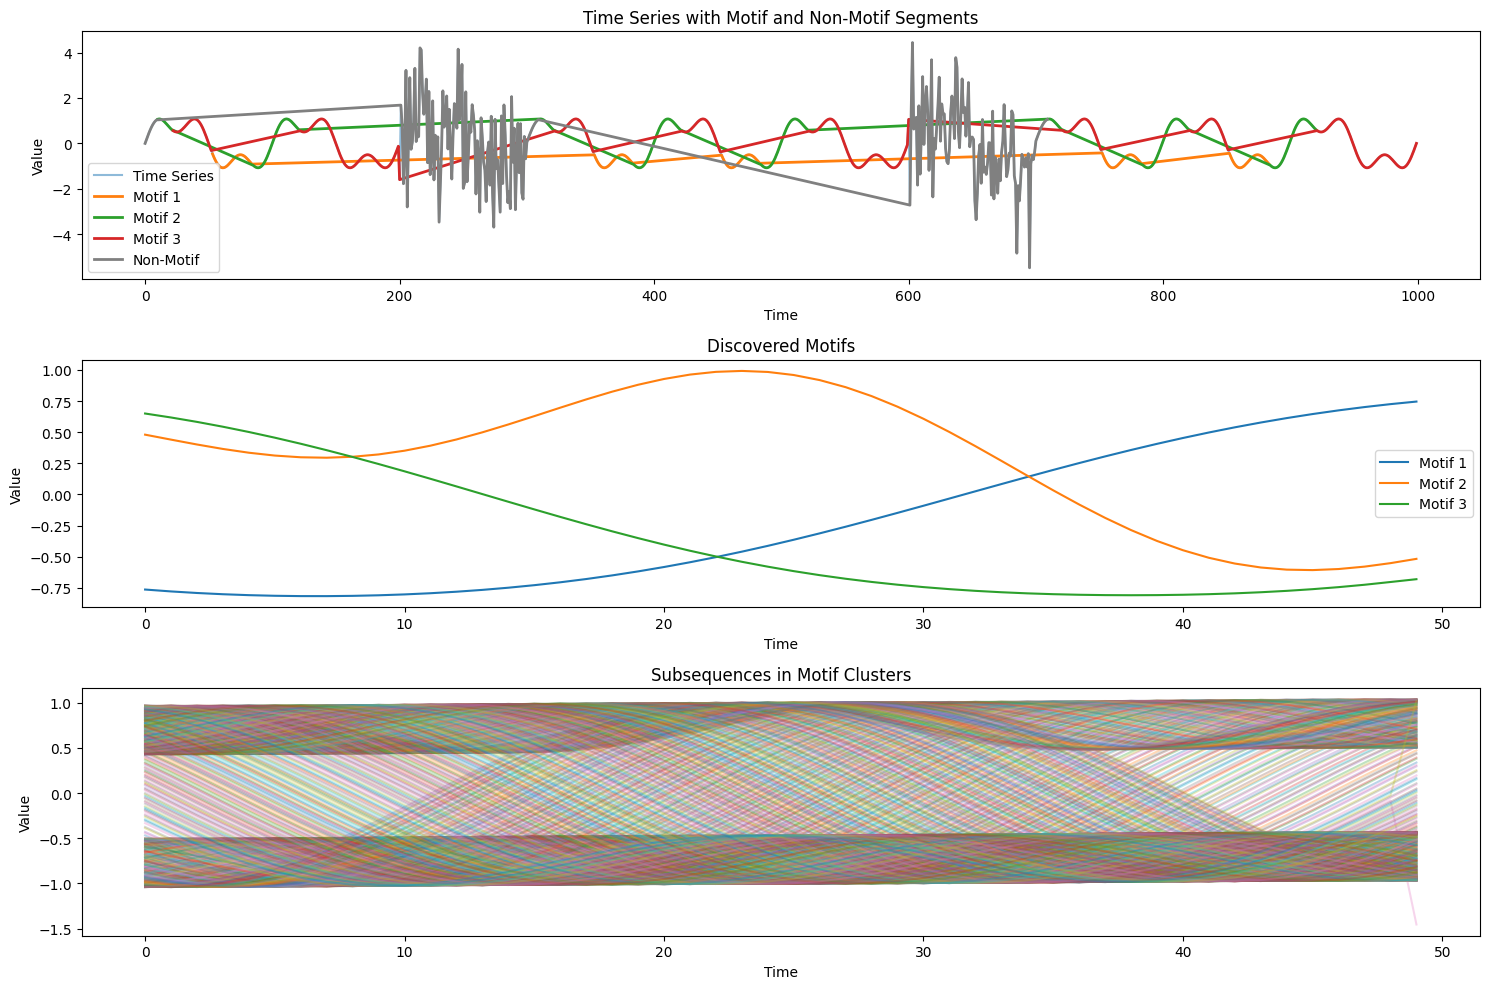

Motif 1: 158 subsequences
Motif 2: 118 subsequences
Motif 3: 245 subsequences
Non-Motif: 430 subsequences


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(123)
np.random.seed(123)

# Generate synthetic time series (mix of motifs and noise)
n_points = 1000
t = np.linspace(0, 20, n_points)
time_series = np.sin(2 * np.pi * 0.5 * t) + 0.5 * np.sin(2 * np.pi * 1.5 * t)
# Add non-motif segments (random noise in some regions)
time_series[200:300] += np.random.normal(0, 1.5, 100)
time_series[600:700] += np.random.normal(0, 1.5, 100)
time_series = torch.tensor(time_series, dtype=torch.float32)

# Function to extract subsequences


def extract_subsequences(time_series, window_size, stride=1):
    """
    Extract subsequences from a time series using a sliding window.

    Args:
        time_series (torch.Tensor): 1D tensor of time series.
        window_size (int): Length of the sliding window.
        stride (int): Step size for sliding window.

    Returns:
        torch.Tensor: Subsequences of shape (num_subsequences, window_size).
        list: Start indices of subsequences.
    """
    num_subsequences = (len(time_series) - window_size) // stride + 1
    subsequences = torch.zeros((num_subsequences, window_size))
    indices = []

    for i in range(num_subsequences):
        start_idx = i * stride
        subsequences[i] = time_series[start_idx : start_idx + window_size]
        indices.append(start_idx)

    return subsequences, indices


# Define convolutional autoencoder


class ConvAutoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * input_size, latent_dim),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8 * input_size),
            nn.ReLU(),
            nn.Unflatten(1, (8, input_size)),
            nn.ConvTranspose1d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


# Train autoencoder


def train_autoencoder(model, data, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        recon, _ = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model


# Main motif discovery and segmentation function


def deep_motif_discovery(
    time_series, window_size, k, latent_dim=16, stride=1, recon_threshold=0.1
):
    """
    Discover motifs and segment time series into motif and non-motif patches using a deep learning approach.

    Args:
        time_series (torch.Tensor): Input time series.
        window_size (int): Length of subsequences.
        k (int): Number of motifs.
        latent_dim (int): Dimension of latent space.
        stride (int): Sliding window stride.
        recon_threshold (float): Reconstruction error threshold for non-motif detection.

    Returns:
        motifs (np.ndarray): Representative motifs (cluster centroids).
        labels (np.ndarray): Cluster labels for subsequences (-1 for non-motifs).
        subsequences (torch.Tensor): Extracted subsequences.
        indices (list): Start indices of subsequences.
        segment_labels (np.ndarray): Labels for each time point (motif ID or -1).
    """
    # Extract subsequences
    subsequences, indices = extract_subsequences(time_series, window_size, stride)

    # Normalize subsequences
    scaler = StandardScaler()
    subsequences_np = scaler.fit_transform(subsequences.numpy())
    subsequences = torch.tensor(subsequences_np, dtype=torch.float32)

    # Reshape for Conv1d: (num_subsequences, channels, window_size)
    subsequences = subsequences.unsqueeze(1)  # Shape: (num_subsequences, 1, window_size)

    # Initialize and train autoencoder
    model = ConvAutoencoder(window_size, latent_dim)
    model = train_autoencoder(model, subsequences)

    # Get latent representations
    model.eval()
    with torch.no_grad():
        _, latents = model(subsequences)
    latents = latents.numpy()

    # Cluster latent representations
    kmeans = KMeans(n_clusters=k, random_state=123)
    labels = kmeans.fit_predict(latents)

    # Compute reconstruction errors
    with torch.no_grad():
        recon, _ = model(subsequences)
    recon_errors = torch.mean((recon - subsequences) ** 2, dim=(1, 2)).numpy()

    # Identify non-motif subsequences (high reconstruction error)
    non_motif_mask = recon_errors > recon_threshold
    labels[non_motif_mask] = -1  # Label non-motifs as -1

    # Compute motifs (average subsequences in each cluster)
    motifs = []
    for i in range(k):
        if np.sum(labels == i) > 0:
            motif = subsequences[labels == i].mean(dim=0).squeeze().numpy()
            motifs.append(scaler.inverse_transform([motif])[0])
        else:
            motifs.append(np.zeros(window_size))  # Placeholder for empty clusters

    # Segment time series
    segment_labels = np.full(len(time_series), -1)  # Initialize as non-motif
    for idx, label in zip(indices, labels):
        if label != -1:  # Only label motif segments
            segment_labels[idx : idx + window_size] = label

    return np.array(motifs), labels, subsequences.squeeze(), indices, segment_labels


# Example usage
window_size = 50
k = 3
recon_threshold = 0.1  # Adjust based on data

motifs, labels, subsequences, indices, segment_labels = deep_motif_discovery(
    time_series, window_size, k, recon_threshold=recon_threshold
)

# Visualize results
plt.figure(figsize=(15, 10))

# Original time series with segments
plt.subplot(3, 1, 1)
plt.plot(time_series.numpy(), label="Time Series", alpha=0.5)
for i in range(k):
    mask = segment_labels == i
    if np.any(mask):
        plt.plot(
            np.arange(len(time_series))[mask],
            time_series.numpy()[mask],
            label=f"Motif {i+1}",
            linewidth=2,
        )
plt.plot(
    np.arange(len(time_series))[segment_labels == -1],
    time_series.numpy()[segment_labels == -1],
    label="Non-Motif",
    linewidth=2,
    color="gray",
)
plt.title("Time Series with Motif and Non-Motif Segments")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Motifs
plt.subplot(3, 1, 2)
for i, motif in enumerate(motifs):
    plt.plot(motif, label=f"Motif {i+1}")
plt.title("Discovered Motifs")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Subsequences by cluster
plt.subplot(3, 1, 3)
for i in range(k):
    for j, label in enumerate(labels):
        if label == i:
            plt.plot(subsequences[j].numpy(), alpha=0.3)
plt.title("Subsequences in Motif Clusters")
plt.xlabel("Time")
plt.ylabel("Value")

plt.tight_layout()
plt.show()

# Print summary
for i in range(k):
    print(f"Motif {i+1}: {np.sum(labels == i)} subsequences")
print(f"Non-Motif: {np.sum(labels == -1)} subsequences")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import stumpy
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

np.random.seed(123)

# 1. Generate synthetic time series data
n_series, n_points = 20, 60
t = np.linspace(0, 10, n_points)
data = []
for i in range(n_series):
    trend = 0.1 * i * t if i < 10 else 0
    cycle = np.sin(2 * np.pi * t * (0.5 + i / 100)) if i < 15 else np.cos(2 * np.pi * t * 0.5)
    noise = np.random.normal(0, 0.2, n_points)
    series = trend + cycle + noise
    data.append(series)
data = np.array(data)

# 2. Normalize each series individually
scaler = StandardScaler()
data_scaled = np.array([scaler.fit_transform(s.reshape(-1, 1)).flatten() for s in data])

In [45]:
# 3. Segment each time series into non-overlapping motifs and non-motifs


def extract_segments(series, min_m=6, max_m=12, threshold=0.5):
    """
    Extract non-overlapping motifs and non-motif segments from a single time series.
    """
    segments = []
    m = np.random.randint(min_m, max_m + 1)
    mp = stumpy.stump(series, m=m)
    print(mp)
    motif_indices = []

    while True:
        idx = np.argmin(mp[:, 0])
        print(idx, motif_indices)
        if mp[idx, 0] > threshold:
            break
        if not any(abs(idx - mi) < m for mi in motif_indices):
            motif_indices.append(idx)
            segments.append((idx, idx + m, "motif"))
            mp[idx : idx + m, 0] = np.inf
        else:
            mp[idx, 0] = np.inf

    motif_mask = np.zeros(len(series), dtype=bool)
    for start, end, _ in segments:
        motif_mask[start:end] = True

    # Extract non-motif segments of length m
    i = 0
    while i <= len(series) - m:
        if not np.any(motif_mask[i : i + m]):
            segments.append((i, i + m, "non-motif"))
            i += m
        else:
            i += 1

    return sorted(segments, key=lambda x: x[0])

[[1.3144121930491646 11 -1 11]
 [0.6690388687820081 25 -1 25]
 [0.5812480829107862 48 -1 48]
 [0.4267993826020745 14 0 14]
 [0.6937356908856793 15 1 15]
 [0.4780279463343169 28 2 28]
 [0.6514599853575324 29 3 29]
 [0.5363373458192364 30 0 30]
 [0.2757055856687797 31 0 31]
 [0.2882023516916109 32 6 32]
 [0.3516100184208665 33 7 33]
 [0.6462006737205246 34 0 34]
 [0.7342142608876175 35 1 35]
 [0.7488449055406725 2 2 36]
 [0.4267993826020745 3 3 37]
 [0.6937356908856793 4 4 38]
 [1.0090171002079797 5 5 28]
 [1.3890821632739998 6 6 29]
 [1.0320659745471779 7 7 30]
 [0.6527196649130695 32 9 32]
 [0.7626592697991015 31 9 31]
 [0.840337680991395 33 10 33]
 [0.7522142597941902 44 9 44]
 [1.2222782892363617 46 0 46]
 [1.136979051578833 47 13 47]
 [0.6690388687820081 1 1 48]
 [0.7233834110817994 49 2 49]
 [0.913874708227482 4 4 37]
 [0.4780279463343169 5 5 51]
 [0.6514599853575324 6 6 52]
 [0.5363373458192364 7 7 43]
 [0.2757055856687797 8 8 44]
 [0.2882023516916109 9 9 45]
 [0.3516100184208665 

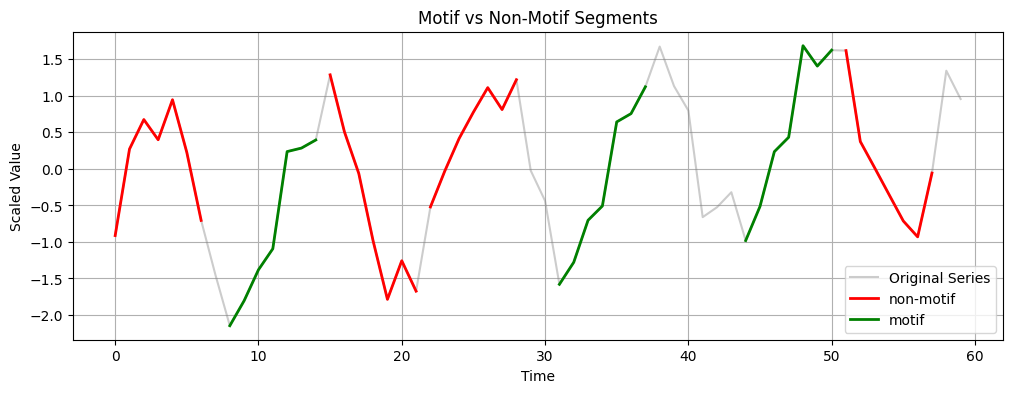

In [48]:
import matplotlib.pyplot as plt

# Extract segments
series = data_scaled[1]  # Or any other TS
segments = extract_segments(series)

# Plot the base series
plt.figure(figsize=(12, 4))
plt.plot(series, color="gray", alpha=0.4, label="Original Series")

# Color-code motifs and non-motifs
colors = {"motif": "green", "non-motif": "red"}
plotted_labels = set()  # To avoid duplicate legend labels

for start, end, label in segments:
    if label not in plotted_labels:
        plt.plot(
            np.arange(start, end), series[start:end], color=colors[label], linewidth=2, label=label
        )
        plotted_labels.add(label)
    else:
        plt.plot(np.arange(start, end), series[start:end], color=colors[label], linewidth=2)

plt.title("Motif vs Non-Motif Segments")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
extract_segments(data[0])

[(0, 7, 'non-motif'),
 (7, 14, 'non-motif'),
 (14, 21, 'non-motif'),
 (np.int64(22), np.int64(29), 'motif'),
 (np.int64(31), np.int64(38), 'motif'),
 (38, 45, 'non-motif'),
 (np.int64(45), np.int64(52), 'motif'),
 (52, 59, 'non-motif')]

/home/pranav-pc/projects/ts/nbs/clustering/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/pranav-pc/projects/ts/nbs/clustering/lab/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


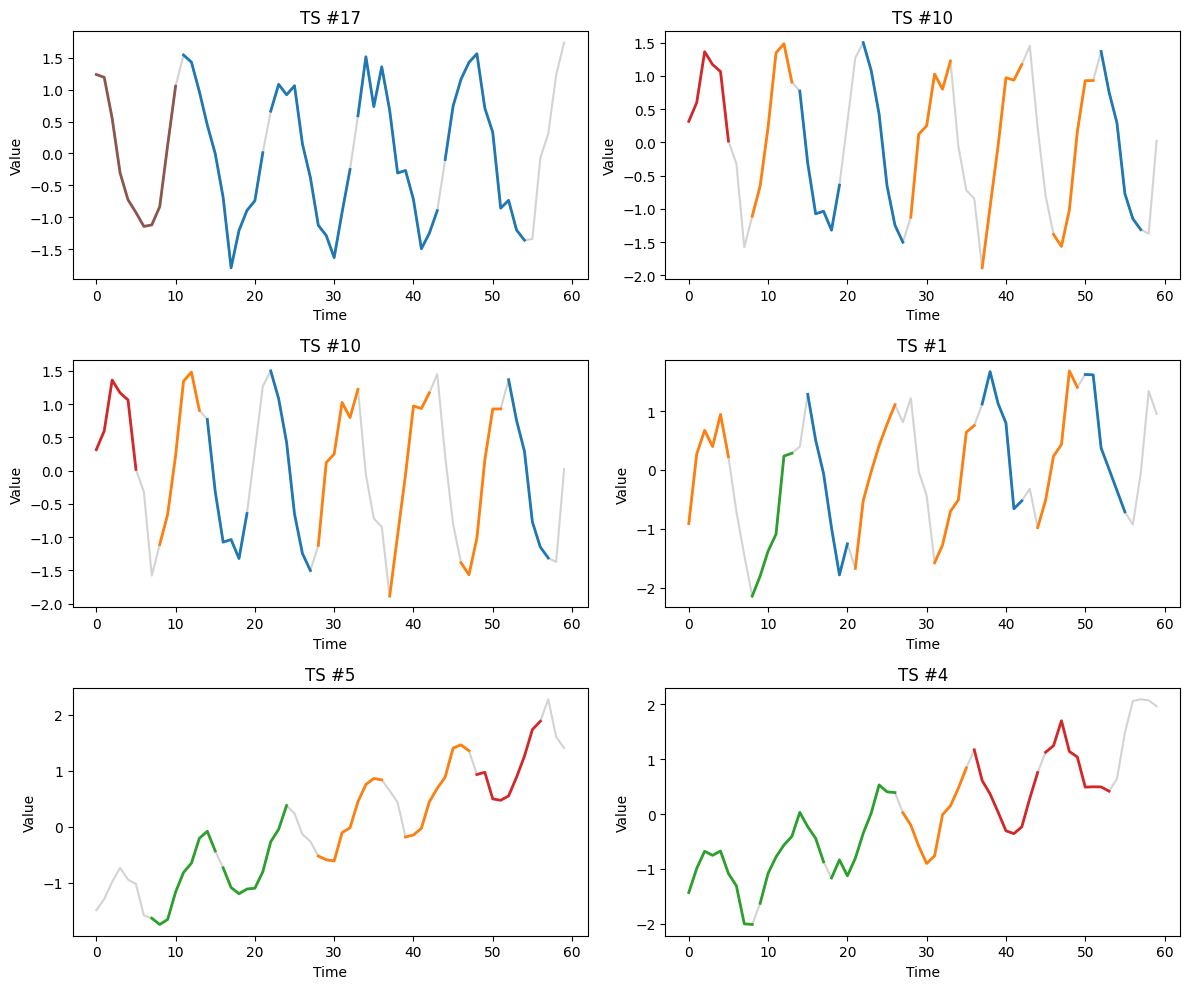

In [15]:
# 4. Collect all segments from all series
all_segments = []
segment_labels = []
segment_map = []  # Keep track of (series_id, segment range)

for i, s in enumerate(data_scaled):
    segments = extract_segments(s)
    for start, end, label in segments:
        all_segments.append(s[start:end])
        segment_labels.append(label)
        segment_map.append((i, start, end))

# Pad segments to the same length
max_len = max(len(seg) for seg in all_segments)
all_segments_padded = np.array(
    [np.pad(seg, (0, max_len - len(seg)), mode="constant") for seg in all_segments]
)

# 5. Cluster the segments
X_ts = to_time_series_dataset(all_segments_padded)
kmeans = TimeSeriesKMeans(n_clusters=6, metric="dtw", random_state=42)
cluster_labels = kmeans.fit_predict(X_ts)

# 6. Visualize some random series with segments colored by cluster
import random

colors = plt.cm.tab10(np.linspace(0, 1, 10))
plt.figure(figsize=(12, 10))
for plot_idx in range(6):
    ts_idx = random.randint(0, n_series - 1)
    plt.subplot(3, 2, plot_idx + 1)
    plt.title(f"TS #{ts_idx}")
    plt.plot(data_scaled[ts_idx], color="lightgray", label="Original")

    for (sid, start, end), clabel in zip(segment_map, cluster_labels):
        if sid == ts_idx:
            plt.plot(
                range(start, end),
                data_scaled[ts_idx][start:end],
                color=colors[clabel],
                linewidth=2,
            )
    plt.xlabel("Time")
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

In [40]:
# Step 2 & 3: Segment each time series into non-overlapping motifs and non-motifs


def segment_time_series(ts, window_size, k_motifs=3, mp_threshold=2.0):
    """
    Segment a time series into non-overlapping motifs and non-motifs using Matrix Profile.

    Args:
        ts (np.ndarray): Scaled time series (1D).
        window_size (int): Length of segments.
        k_motifs (int): Number of motifs to identify.
        mp_threshold (float): Matrix Profile threshold for non-motif detection.

    Returns:
        segments (np.ndarray): Extracted segments (shape: num_segments, window_size).
        segment_indices (list): Start indices of segments.
        segment_labels (np.ndarray): Labels (motif ID or -1 for non-motifs).
        segment_types (list): Type of each segment ('motif' or 'non-motif').
        motifs (np.ndarray): Representative motifs (shape: k_motifs, window_size).
    """
    # Compute Matrix Profile
    mp = stumpy.stump(ts, m=window_size)
    mp_distances = mp[:, 0]  # Distance to nearest neighbor

    # Find top-K motifs
    motif_indices, _ = stumpy.motifs(ts, mp_distances, max_motifs=k_motifs)
    motif_indices = motif_indices[0].astype(int)

    # Initialize segmentation
    segments = []
    segment_indices = []
    segment_labels = []
    segment_types = []
    covered = np.zeros(len(ts), dtype=bool)  # Track covered regions

    # Greedily select non-overlapping motifs
    for motif_idx, start in enumerate(motif_indices):
        if start + window_size <= len(ts) and not covered[start : start + window_size].any():
            segments.append(ts[start : start + window_size])
            segment_indices.append(start)
            segment_labels.append(motif_idx)
            segment_types.append("motif")
            covered[start : start + window_size] = True

    # Add non-motif segments for uncovered regions
    i = 0
    while i < len(ts) - window_size + 1:
        if not covered[i : i + window_size].any():
            mp_idx = min(i, len(mp_distances) - 1)
            if mp_distances[mp_idx] > mp_threshold:  # High distance indicates non-motif
                segments.append(ts[i : i + window_size])
                segment_indices.append(i)
                segment_labels.append(-1)
                segment_types.append("non-motif")
                covered[i : i + window_size] = True
            i += window_size  # Move to next non-overlapping position
        else:
            i += 1

    # Convert segments to array
    segments = np.array(segments)

    # Store motifs
    motifs = np.array([ts[idx : idx + window_size] for idx in motif_indices])

    return segments, segment_indices, np.array(segment_labels), segment_types, motifs

Processing time series 1/10
Processing time series 2/10
Processing time series 3/10
Processing time series 4/10
Processing time series 5/10
Processing time series 6/10
Processing time series 7/10
Processing time series 8/10
Processing time series 9/10
Processing time series 10/10


ValueError: operands could not be broadcast together with shapes (1,100) (10,) (1,100) 

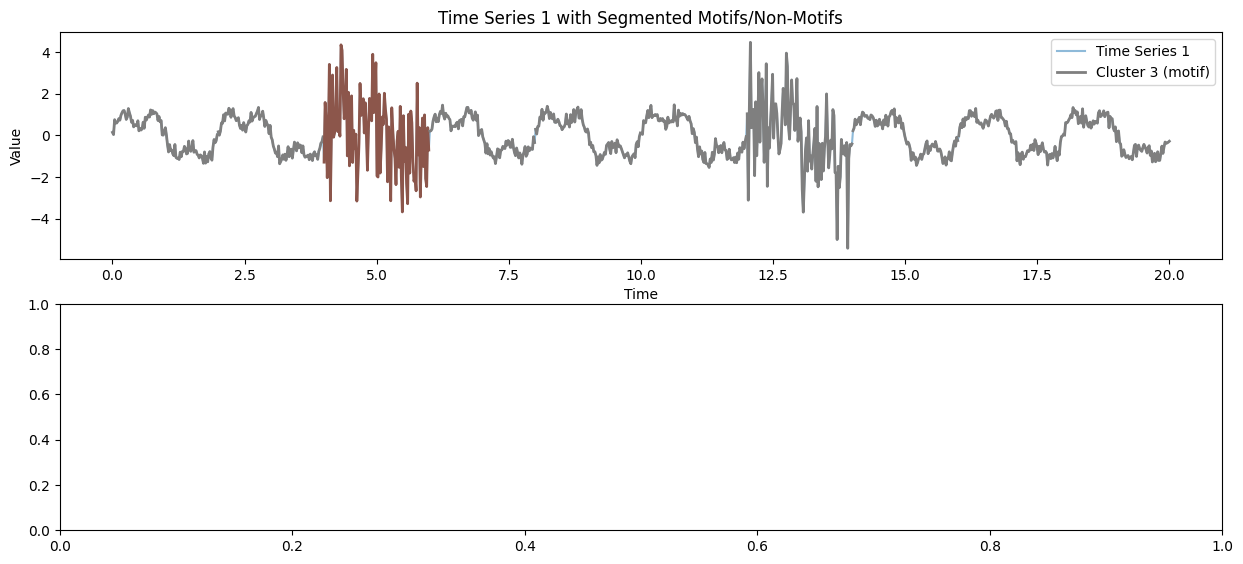

In [39]:
import random

import matplotlib.pyplot as plt
import numpy as np
import stumpy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(123)
random.seed(123)

# Generate synthetic time series dataset (m time series, n timestamps)
m, n = 10, 1000  # m: number of time series, n: number of timestamps
t = np.linspace(0, 20, n)
time_series_list = []
window_sizes = []
for i in range(m):
    # Mix of motifs (sine waves) with varying frequencies
    freq = 0.5 + i * 0.05
    motif1 = np.sin(2 * np.pi * freq * t)
    motif2 = 0.5 * np.sin(2 * np.pi * (freq + 1.0) * t)
    series = motif1 + motif2
    # Add non-motif segments (random noise in some regions)
    series[200:300] += np.random.normal(0, 1.5, 100)
    series[600:700] += np.random.normal(0, 1.5, 100)
    series += np.random.normal(0, 0.2, n)  # Add noise
    time_series_list.append(series)
    # Vary window size based on frequency (heuristic: shorter windows for higher frequencies)
    window_size = int(100 / (freq + 0.5))  # Example heuristic
    window_sizes.append(window_size)
time_series_list = np.array(time_series_list)  # Shape: (m, n)

# Step 1: Scale each time series individually
scaler = StandardScaler()
time_series_scaled = scaler.fit_transform(time_series_list.T).T  # Shape: (m, n)

# Step 2 & 3: Segment each time series into non-overlapping motifs and non-motifs


def segment_time_series(ts, window_size, k_motifs=3, mp_threshold=2.0):
    """
    Segment a time series into non-overlapping motifs and non-motifs using Matrix Profile.

    Args:
        ts (np.ndarray): Scaled time series (1D).
        window_size (int): Length of segments.
        k_motifs (int): Number of motifs to identify.
        mp_threshold (float): Matrix Profile threshold for non-motif detection.

    Returns:
        segments (np.ndarray): Extracted segments (shape: num_segments, window_size).
        segment_indices (list): Start indices of segments.
        segment_labels (np.ndarray): Labels (motif ID or -1 for non-motifs).
        segment_types (list): Type of each segment ('motif' or 'non-motif').
        motifs (np.ndarray): Representative motifs (shape: k_motifs, window_size).
    """
    # Compute Matrix Profile
    mp = stumpy.stump(ts, m=window_size)
    mp_distances = mp[:, 0]  # Distance to nearest neighbor

    # Find top-K motifs
    motif_indices, _ = stumpy.motifs(ts, mp_distances, max_motifs=k_motifs)
    motif_indices = motif_indices[0].astype(int)

    # Initialize segmentation
    segments = []
    segment_indices = []
    segment_labels = []
    segment_types = []
    covered = np.zeros(len(ts), dtype=bool)  # Track covered regions

    # Greedily select non-overlapping motifs
    for motif_idx, start in enumerate(motif_indices):
        if start + window_size <= len(ts) and not covered[start : start + window_size].any():
            segments.append(ts[start : start + window_size])
            segment_indices.append(start)
            segment_labels.append(motif_idx)
            segment_types.append("motif")
            covered[start : start + window_size] = True

    # Add non-motif segments for uncovered regions
    i = 0
    while i < len(ts) - window_size + 1:
        if not covered[i : i + window_size].any():
            mp_idx = min(i, len(mp_distances) - 1)
            if mp_distances[mp_idx] > mp_threshold:  # High distance indicates non-motif
                segments.append(ts[i : i + window_size])
                segment_indices.append(i)
                segment_labels.append(-1)
                segment_types.append("non-motif")
                covered[i : i + window_size] = True
            i += window_size  # Move to next non-overlapping position
        else:
            i += 1

    # Convert segments to array
    segments = np.array(segments)

    # Store motifs
    motifs = np.array([ts[idx : idx + window_size] for idx in motif_indices])

    return segments, segment_indices, np.array(segment_labels), segment_types, motifs


# Process all time series
k_motifs = 3
mp_threshold = 2.0
all_results = []
all_segments = []  # For clustering
all_segment_labels = []  # For clustering
all_segment_ts_indices = []  # Track source time series
max_window_size = max(window_sizes)  # For padding

for i, (ts, window_size) in enumerate(zip(time_series_scaled, window_sizes)):
    print(f"Processing time series {i+1}/{m}")
    segments, segment_indices, segment_labels, segment_types, motifs = segment_time_series(
        ts, window_size, k_motifs=k_motifs, mp_threshold=mp_threshold
    )
    # Pad segments to max_window_size
    padded_segments = np.zeros((len(segments), max_window_size))
    for j, segment in enumerate(segments):
        padded_segments[j, : len(segment)] = segment
        if len(segment) < max_window_size:
            padded_segments[j, len(segment) :] = segment[-1]  # Pad with last value
    all_results.append(
        {
            "series_idx": i,
            "segments": segments,  # Original segments
            "padded_segments": padded_segments,  # Padded for clustering
            "segment_indices": segment_indices,
            "segment_labels": segment_labels,
            "segment_types": segment_types,
            "motifs": motifs,
            "window_size": window_size,
        }
    )
    # Collect padded segments for clustering
    all_segments.append(padded_segments)
    all_segment_labels.append(segment_labels)
    all_segment_ts_indices.extend([i] * len(segments))

# Step 4: Cluster all segments
# Concatenate padded segments from all time series
all_segments = np.concatenate(all_segments, axis=0)  # Shape: (total_segments, max_window_size)
k_clusters = 5  # Number of clusters (adjust based on data)
kmeans = KMeans(n_clusters=k_clusters, random_state=123)
cluster_labels = kmeans.fit_predict(all_segments)

# Assign cluster labels back to results
segment_idx = 0
for result in all_results:
    n_segments = len(result["segments"])
    result["cluster_labels"] = cluster_labels[segment_idx : segment_idx + n_segments]
    segment_idx += n_segments

# Step 5: Visualize random time series
n_visualize = 3
random_indices = random.sample(range(m), n_visualize)

for idx in random_indices:
    result = all_results[idx]
    ts = time_series_list[idx]  # Original (unscaled) for visualization
    segments = result["segments"]
    segment_indices = result["segment_indices"]
    segment_labels = result["segment_labels"]
    segment_types = result["segment_types"]
    cluster_labels = result["cluster_labels"]
    motifs = result["motifs"]
    window_size = result["window_size"]

    plt.figure(figsize=(15, 10))

    # Time series with segmented regions
    plt.subplot(3, 1, 1)
    plt.plot(t, ts, label=f"Time Series {idx+1}", alpha=0.5)
    colors = plt.cm.tab10(np.linspace(0, 1, k_clusters))
    for i, (start, cluster_label, segment_type) in enumerate(
        zip(segment_indices, cluster_labels, segment_types)
    ):
        segment = ts[start : start + window_size]
        plt.plot(
            t[start : start + window_size],
            segment,
            color=colors[cluster_label],
            linewidth=2,
            label=f"Cluster {cluster_label} ({segment_type})" if i == 0 else None,
        )
    plt.title(f"Time Series {idx+1} with Segmented Motifs/Non-Motifs")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

    # Motifs
    plt.subplot(3, 1, 2)
    for i, motif in enumerate(motifs):
        # Inverse scale for visualization
        motif_unscaled = scaler.inverse_transform([motif])[0]
        plt.plot(motif_unscaled, label=f"Motif {i+1}")
    plt.title(f"Discovered Motifs (Series {idx+1})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

    # Segments by cluster
    plt.subplot(3, 1, 3)
    for i, (segment, cluster_label) in enumerate(zip(segments, cluster_labels)):
        # Inverse scale for visualization
        segment_unscaled = scaler.inverse_transform([segment])[0]
        plt.plot(segment_unscaled, color=colors[cluster_label], alpha=0.3)
    plt.title(f"Segments in Clusters (Series {idx+1})")
    plt.xlabel("Time")
    plt.ylabel("Value")

    plt.tight_layout()
    plt.show()

    # Print summary
    for cluster in range(k_clusters):
        cluster_count = np.sum(cluster_labels == cluster)
        print(f"Series {idx+1}, Cluster {cluster}: {cluster_count} segments")
    motif_count = np.sum(np.array(segment_types) == "motif")
    non_motif_count = np.sum(np.array(segment_types) == "non-motif")
    print(f"Series {idx+1}, Motifs: {motif_count} segments")
    print(f"Series {idx+1}, Non-Motifs: {non_motif_count} segments")